In [106]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rotten-tomatoes-reviews/rt_reviews.csv


In [107]:
data = "/kaggle/input/rotten-tomatoes-reviews/rt_reviews.csv"

In [108]:
import pandas as pd
dataset = pd.read_csv(data, encoding='latin-1')

In [109]:
dataset

,Freshness,Review
0,fresh,"Manakamana doesn't answer any questions, yet ..."
1,fresh,Wilfully offensive and powered by a chest-thu...
2,rotten,It would be difficult to imagine material mor...
3,rotten,Despite the gusto its star brings to the role...
4,rotten,If there was a good idea at the core of this ...
...,...,...
479995,rotten,Zemeckis seems unable to admit that the motio...
479996,fresh,Movies like The Kids Are All Right -- beautif...
479997,rotten,Film-savvy audiences soon will catch onto Win...
479998,fresh,An odd yet enjoyable film.


In [110]:
unique1 = dataset['Freshness'].unique()
print("Total number of Categories : " + str(len(unique1)))
print("Categories are : ")
count = 1
for type in unique1:
  print(str(count) + ". " + type)
  count += 1

Total number of Categories : 2
Categories are : 
1. fresh
2. rotten


Cleaning the dataset of common terms

In [111]:
dataset['Review'] = dataset['Review'].str.lower()
dataset['Review'] = dataset['Review'].str.replace('[^\w\s]',' ')
dataset

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,Freshness,Review
0,fresh,manakamana doesn t answer any questions yet ...
1,fresh,wilfully offensive and powered by a chest thu...
2,rotten,it would be difficult to imagine material mor...
3,rotten,despite the gusto its star brings to the role...
4,rotten,if there was a good idea at the core of this ...
...,...,...
479995,rotten,zemeckis seems unable to admit that the motio...
479996,fresh,movies like the kids are all right beautif...
479997,rotten,film savvy audiences soon will catch onto win...
479998,fresh,an odd yet enjoyable film


In [112]:
from sklearn.model_selection import train_test_split
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from collections import defaultdict
import matplotlib.pyplot as plt

nltk.download('stopwords')
stop_words_sentence = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Split the dataset in train, test, development set

In [113]:
train_size = 0.8
dev_size = 0.1
test_size = 0.1

train_index = int(len(dataset)*train_size)

# First we need to sort the dataset by the desired column 
dataset.sort_values(by = 'Freshness', ascending=True, inplace=True)

dataset_train = dataset[0:train_index]
dataset_rem = dataset[train_index:]
dataset_rem

dev_index = int(len(dataset)*dev_size)
dataset_dev = dataset[train_index:train_index+dev_index]
dataset_test = dataset[train_index+dev_index:]

In [114]:
dataset_train_X = dataset_train['Review']
dataset_dev_X = dataset_dev['Review']
dataset_test_X = dataset_test['Review']

dataset_train_y = dataset_train['Freshness']
dataset_dev_y = dataset_dev['Freshness']
dataset_test_y = dataset_test['Freshness']

unique_training_types = list(dataset_train_y.unique())
#print(unique_training_types)
dict_types = {}
for class_type in unique_training_types:
  dict_types[class_type] = sum(dataset_train_y == class_type)

for key_type, count in dict_types.items():
  print(key_type + ": " + str(count))

fresh: 240000
rotten: 144000


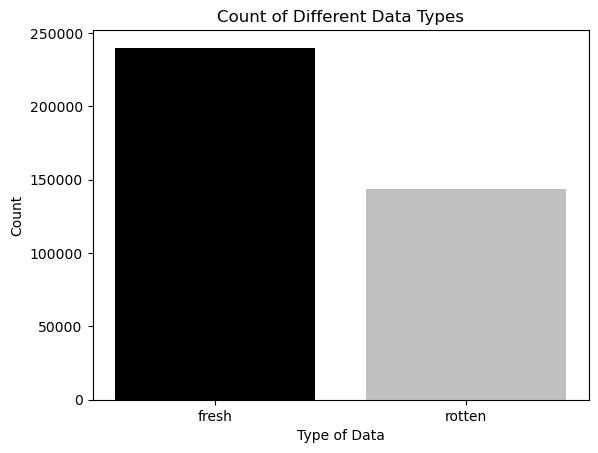

In [115]:
import numpy as np 
import matplotlib.pyplot as plt 
  
labels = dict_types.keys()
count = dict_types.values()
# Plot
plt.bar(labels, count, color=['black', 'silver'])

# add labels and title
plt.xlabel('Type of Data')
plt.ylabel('Count')
plt.title('Count of Different Data Types')

plt.show()


Define the prior probabilities

In [116]:
def prior_probabilities(): 
  sentence_type_prior_probabilities = dict()
  total_type_count = dataset_train_y.size
    
  for sentence_type, sentence_type_count in dict_types.items():
    sentence_type_prior_probabilities[sentence_type] = sentence_type_count / total_type_count;
  return sentence_type_prior_probabilities

for sentence_type, prior_probability in prior_probabilities().items():
    print(f"{sentence_type}: {prior_probability}")

fresh: 0.625
rotten: 0.375


Vocabulary Builder Fn

In [117]:
def build_vocabulary(sentences, remove_stopwords=False, min_word_count=5):
    # Initialize stop words
    stop_words = set(stopwords.words('english'))
    
    # Initialize vocabulary list and dictionary of word counts
    vocabulary_list = []
    word_counts = {}
    
    # Loop through each sentence
    for sentence in sentences:
        # Split the sentence into words
        words_in_sentence = str(sentence).split()
        
        # Loop through each word in the sentence
        for word in words_in_sentence:
            # Remove digits and white spaces from the word
            word = re.sub(r'\d', ' ', word).strip()
            
            # Skip empty words
            if not word:
                continue
            
            # Skip stop words if requested
            if remove_stopwords and word in stop_words:
                continue  
            
            # Increment the word count for the current word
            if word in word_counts:
                word_counts[word] += 1
            else:
                word_counts[word] = 1
                vocabulary_list.append(word)
    
    # Filter out words with a count less than the minimum count
    word_counts = {word: count for word, count in word_counts.items() if count >= min_word_count}
    
    return word_counts, vocabulary_list

In [118]:
import itertools
dictionary_word_count, vocabulary_list = build_vocabulary(dataset_train_X)
dict_word_count = dict(itertools.islice(dictionary_word_count.items(), 10))
print(vocabulary_list[:10])
print(dict_word_count)
print(len(vocabulary_list))

['manakamana', 'doesn', 't', 'answer', 'any', 'questions', 'yet', 'makes', 'its', 'point']
{'manakamana': 6, 'doesn': 10820, 't': 42034, 'answer': 527, 'any': 9211, 'questions': 1329, 'yet': 6518, 'makes': 9784, 'its': 50835, 'point': 3496}
81356


Calculate probability

In [119]:
def calculate_word_probabilities(data, remove_stopwords=False):
    # Get the vocabulary and word counts
    word_counts, vocabulary = build_vocabulary(data, remove_stopwords)
    
    # Get the total number of words
    total_word_count = sum(word_counts.values())
    
    # Calculate the probability of each word
    word_probabilities = {}
    for word, count in word_counts.items():
        word_probabilities[word] = count / total_word_count
    
    return word_probabilities

In [120]:
probability_each_word = calculate_word_probabilities(dataset_train_X, True)
pew = dict(itertools.islice(probability_each_word.items(), 10))
print(pew)
print(len(probability_each_word))

{'manakamana': 1.266739166371622e-06, 'answer': 0.00011126192344630746, 'questions': 0.00028058272535131425, 'yet': 0.001376100981068372, 'makes': 0.002065629333963325, 'point': 0.000738086687605865, 'like': 0.005851701579053708, 'rest': 0.00027530464549143253, 'planet': 0.00011485101775102706, 'picturesque': 1.287851485811149e-05}
36952


Calculate Conditional Probability

In [121]:
def calculate_conditional_probability(class_type, data, remove_stopwords=False):
    
    conditional_probabilities = {}
    # Get the sentences for the specified class
    sentences = data.loc[data.Freshness == class_type].Review
    
    # Get the word counts and vocabulary for the sentences
    word_counts = {}
    vocabulary = []
    word_counts, vocabulary = build_vocabulary(sentences, remove_stopwords)
    
    # Calculate the conditional probability of each word
    
    for word, count in word_counts.items():
        conditional_probabilities[word] = count / sum(word_counts.values())
    
    return conditional_probabilities

In [122]:
sentence_types = dataset_train_y.unique()

In [123]:
import operator
for each_sentence_type in sentence_types:  
  conditional_probability = calculate_conditional_probability(each_sentence_type, dataset_train, True)
  print("Sentence Type : " + each_sentence_type.upper())
  sorted_probability = dict(sorted(conditional_probability.items(), key = lambda x: x[1], reverse = True)[:10])
  print(sorted_probability)
  # Let's find top 10 words that predicts each class before removing stop words
  sorted_probability = dict(sorted(conditional_probability.items(), key=operator.itemgetter(1), reverse=True)[:10])
  print("Top 10 words: ")
  print(sorted_probability)
  print()

Sentence Type : FRESH
{'film': 0.014391485702749453, 'movie': 0.008744418830665797, 'one': 0.007307751897949698, 'like': 0.005030681759494443, 'story': 0.004741604519531493, 'good': 0.0035309678185265645, 'best': 0.0034018555941811635, 'even': 0.003252286627796621, 'well': 0.0031754900060431226, 'full': 0.003024914970377967}
Top 10 words: 
{'film': 0.014391485702749453, 'movie': 0.008744418830665797, 'one': 0.007307751897949698, 'like': 0.005030681759494443, 'story': 0.004741604519531493, 'good': 0.0035309678185265645, 'best': 0.0034018555941811635, 'even': 0.003252286627796621, 'well': 0.0031754900060431226, 'full': 0.003024914970377967}

Sentence Type : ROTTEN
{'film': 0.012636642810395917, 'movie': 0.011959941133978736, 'like': 0.007443718440588988, 'one': 0.006636476561887178, 'much': 0.004781986154543209, 'story': 0.004383340962813018, 'even': 0.003947231318409213, 'good': 0.0033448731652662377, 'time': 0.003164575486774463, 'comedy': 0.0030650605343601717}
Top 10 words: 
{'film':

In [124]:
probability_each_word_dev = calculate_word_probabilities(dataset_dev_X, True)
pew_d = dict(itertools.islice(probability_each_word_dev.items(), 10))
print(pew_d)

{'powerful': 0.0001890560413500437, 'system': 0.00011563621946653158, 'get': 0.002028222579532022, 'far': 0.0014720674287644177, 'one': 0.00710887425387106, 'half': 0.0012609854408493204, 'film': 0.01323208739895597, 'harrowing': 3.670991094175606e-05, 'emotionally': 0.0002624758632335558, 'resonate': 4.038090203593166e-05}


In [125]:
probability_each_word_test = calculate_word_probabilities(dataset_test_X, True)
pew_t = dict(itertools.islice(probability_each_word_test.items(), 10))
print(pew_t)

{'amounts': 0.00013195537708998075, 'little': 0.002972661411665955, 'nihilistic': 4.5817839267354424e-05, 'tale': 0.000953011056760972, 'one': 0.006726058804447629, 'man': 0.0012828994994859239, 'self': 0.0011362824138303896, 'loathing': 2.5657989989718477e-05, 'unconvincingly': 1.2828994994859238e-05, 'passing': 4.0319698555271894e-05}


Probability on Dev Set

In [126]:
dev_sen = dataset_dev_X.iloc[457]
dev_sen = str(dev_sen).replace('[^\w\s]', ' ')
print("Development Sentence: " + dev_sen)

# Calculate the prior probabilities for each class
prior_probability = prior_probabilities()

# Calculate the accuracy for each sentence type
accuracies = {}
for sentence_type in sentence_types:  
  # Calculate the conditional probabilities for the current sentence type
  conditional_probability = calculate_conditional_probability(sentence_type, dataset_train, True)
  
  # Calculate the probability of each word in the test sentence
  word_probabilities = calculate_word_probabilities(dataset_train_X, True)
  
  # Calculate the prior probability for the current sentence type
  prior_prob = prior_probability[sentence_type]
  
  # Calculate the probability of the test sentence belonging to the current sentence type
  probability = 1
  denominator = 1
  for word in dev_sen.split():
    if word in stop_words_sentence or (word not in conditional_probability.keys()):
      continue
    count_prob = 0
    for val in conditional_probability.values():
      count_prob += val
    probability *= conditional_probability[word]
    denominator *= word_probabilities[word]
  accuracies[sentence_type] = probability * prior_prob / denominator

# Determine the sentence type with the highest accuracy
highest_accuracy = 0
predicted_class = ''
for sentence_type in sentence_types:
  if accuracies[sentence_type] > highest_accuracy:
    highest_accuracy = accuracies[sentence_type]
    predicted_class = sentence_type
  
print("Predicted Sentence Type: "+ predicted_class)
print("Accuracy: " +str(highest_accuracy))

Development Sentence:  the action scenes are surprisingly good and the comedy has its moments  but the script leans too heavily on mckinnon to provide levity without always giving her much to work with 
Predicted Sentence Type: rotten
Accuracy: 0.6701222425031064


Laplace Smoothing

In [132]:
def laplace_smoothing(dev_sentence, alpha):
    dev_sentence = str(dev_sentence).replace('[^\w\s]', ' ')
    print("Sentence: " + dev_sentence)

    # Calculate the prior probabilities for each class
    prior_probability = prior_probabilities()
    k = 1
    # Calculate the accuracy for each sentence type
    accuracies = {}
    for sentence_type in sentence_types:  
      # Calculate the conditional probabilities for the current sentence type
      conditional_probability = calculate_conditional_probability(sentence_type, dataset_train, True)

      # Calculate the probability of each word in the test sentence
      word_probabilities = calculate_word_probabilities(dataset_train_X, True)

      # Calculate the prior probability for the current sentence type
      prior_prob = prior_probability[sentence_type]

      # Calculate the probability of the test sentence belonging to the current sentence type
      probability = 1
      denominator = 1
      for word in dev_sentence.split():
        if word in stop_words_sentence or (word not in conditional_probability.keys()):
          continue
        count_prob = 0
        for val in conditional_probability.values():
          count_prob += val
        probability *= conditional_probability[word]
        denominator *= word_probabilities[word]
      accuracies[sentence_type] = probability + alpha / denominator + alpha * k #smoothing

    # Determine the sentence type with the highest accuracy
    highest_accuracy = 0
    predicted_class = ''
    for sentence_type in sentence_types:
      if accuracies[sentence_type] > highest_accuracy:
        highest_accuracy = accuracies[sentence_type]
        predicted_class = sentence_type
    return predicted_class,str(highest_accuracy)
    

Experimenting on the basis of alpha

In [133]:
alpha = 0
dev_sentence = dataset_dev_X.iloc[457]
class_type_m, high_probability = laplace_smoothing(dev_sentence, alpha)
print("Type : "+ class_type_m)
print("Accuracy: " +str(accuracy_0))

Sentence:  the action scenes are surprisingly good and the comedy has its moments  but the script leans too heavily on mckinnon to provide levity without always giving her much to work with 
Type : rotten
Accuracy: 0.7550833333333333


In [134]:
alpha = 1
dev_sentence = dataset_dev_X.iloc[457]
class_type_1, high_probability_1 = laplace_smoothing(dev_sentence, alpha)
print("Type : "+ class_type_m)
print("Accuracy: " +str(accuracy_1))

Sentence:  the action scenes are surprisingly good and the comedy has its moments  but the script leans too heavily on mckinnon to provide levity without always giving her much to work with 
Type : rotten
Accuracy: 0.8023750000000001


In [135]:
alpha = 0.1
dev_sentence = dataset_dev_X.iloc[457]
class_type_01, high_probability_01 = laplace_smoothing(dev_sentence, alpha)
print("Type : "+ class_type_m)
print("Accuracy: " +str(accuracy_01))

Sentence:  the action scenes are surprisingly good and the comedy has its moments  but the script leans too heavily on mckinnon to provide levity without always giving her much to work with 
Type : rotten
Accuracy: 0.7821041666666667


In [136]:
alpha = 0.01
dev_sentence = dataset_dev_X.iloc[457]
class_type_001, high_probability_001 = laplace_smoothing(dev_sentence, alpha)
print("Type : "+ class_type_m)
print("Accuracy: " +str(accuracy_001))

Sentence:  the action scenes are surprisingly good and the comedy has its moments  but the script leans too heavily on mckinnon to provide levity without always giving her much to work with 
Type : rotten
Accuracy: 0.7751041666666667


Compare Smoothing Results

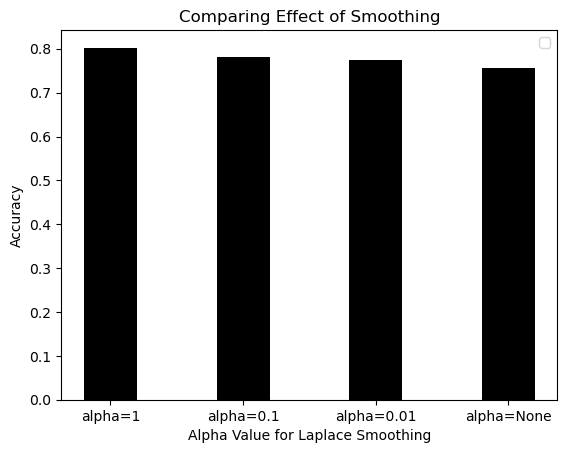

In [140]:
import numpy as np 
import matplotlib.pyplot as plt 
  
# Here 'alpha=None' is without smoothing
X = ['alpha=1','alpha=0.1','alpha=0.01', 'alpha=None']
accuracies = [accuracy_1, accuracy_01, accuracy_001, accuracy_0]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis,  accuracies, 0.4, label = None, color = 'black')
  
plt.xticks(X_axis, X)
plt.xlabel("Alpha Value for Laplace Smoothing")
plt.ylabel("Accuracy")
plt.title("Comparing Effect of Smoothing")
plt.legend()
plt.show()

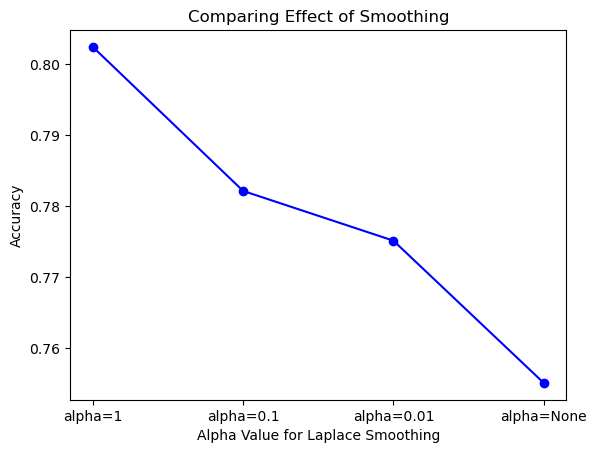

In [141]:
X_axis = np.arange(len(X))
plt.plot(X_axis, accuracies, 'bo-')
plt.xticks(X_axis, X)
plt.xlabel("Alpha Value for Laplace Smoothing")
plt.ylabel("Accuracy")
plt.title("Comparing Effect of Smoothing")
plt.show()

Final Accuracy using Smoothing on Test Data

In [139]:
alpha = 1
test_sentence = dataset_test_X.iloc[5411]
class_type, high_probability = laplace_smoothing(test_sentence, alpha)
print("Type : "+ class_type_m)
print("Accuracy: " +str(test_acc))

Sentence:  comic desperation can be seen at alarmingly frequent intervals 
Type : rotten
Accuracy: 0.85525
